# Case 1: Dropping an egg in boiling water

## Setting up toy model

In [45]:
# Baseline packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.sparse        import diags_array
from scipy.sparse.linalg import spsolve
from scipy import sparse
%matplotlib inline

# Physical parameters
alpha = 1.3e-7        # thermal diffusivity (m^2/s)
L = 0.04              # domain length, egg diameter = 4 cm
T_d = [100.0,100.0]   # boiling water on edges 
T_0=20.0              # Room temp


#Heating water up
#Linear process
#depends on mass,m heat capacity, c and power p
def Water_temp(t,mass = 1, c = 4186, power =1000):
    Temp_t = T_0 + power/(mass*c)*t
    if Temp_t>=100.0:
        Temp_t = 100.0
    return [Temp_t,Temp_t]
    
# Initial conditions
def I_egg(x):
    ''' Computes the initial condition of 20deg'''
    i_x = T_0 * np.ones_like(x) # note that ones_like produces a vector of 1's the same size as its argument
    return i_x
    
Nx = 101               # number of spatial points
x = np.linspace(-L/2, L/2, Nx)  # spatial domain
dx = x[1] - x[0]


# Time parameters
t_max = 3600.0 
Nt = 3601
t = np.linspace(0.0,t_max,Nt)
dt = t[1] - t[0]

C = dt*alpha/(dx**2)

# Initialise U
U_1 = np.zeros((Nt,Nx))
U_1[0] = I_egg(x)
# Enforce boundary conditions for all space points
U_1[:,[0,-1]] = T_d

# Backwards Euler matrix
# Values on the three non-zero diagonals
diags = np.ones((3,Nx))
# Add 2C to main diagonal except at the endpoints (first index = 0 represents the main diagonal here)
diags[0,1:-1] += 2 * C             
diags[1:] = - C;    
diags[1,0] = 0.0
diags[2,-2] = 0.0 
# Create the matrix, taking care of the order in which we defined the diagonals
A = diags_array(diags, offsets = (0,1,-1), shape = (Nx, Nx), format = 'csr')

center = []
cent_i = 50
## Iterate
for n in range(0, Nt - 1):
    center.append(U_1[n,cent_i])
    U_1[n+1] = spsolve(A, U_1[n])


U_test = U_1

## Exact solution to toy model

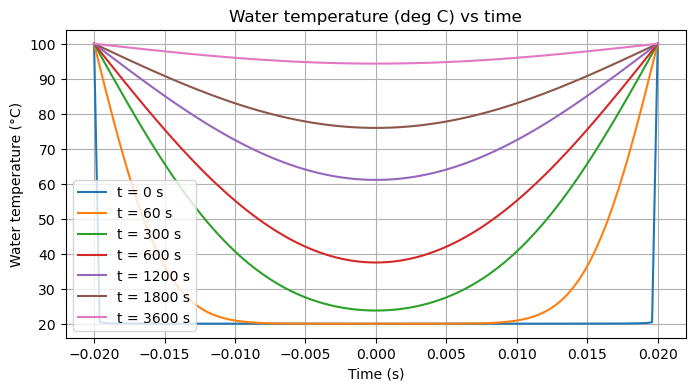

In [46]:
U_0 = 20.0
L= 0.02
def k_func(n):
    return (2*n+1)*np.pi/(2*L)

def U_exact_egg(x,t, K = 2000):

    # Start with the x term
    u_exact = np.ones_like(x)*100.0

    # Loop to add in each k-dependent term
    for i in range(K):
        #Find k_n value
        k = k_func(i)
        #Find each factor of each term, multiply then add
        ak = 2*-80.0*((-1)**i)/(k*L)
        bk = np.cos(k*x)
        ck = np.exp(-alpha*k**2*t)
        u_exact += ak*bk*ck    
    return u_exact


plt.figure(figsize=(8,4))
for t_i in [0, 60, 300, 600, 1200, 1800, 3600]:
    plt.plot(x, U_exact_egg(x, t_i), label=f"t = {t_i} s")
plt.xlabel("Time (s)")
plt.ylabel("Water temperature (°C)")
plt.title("Water temperature (deg C) vs time")
plt.legend()
plt.grid(True)
plt.show()


## Setting up plotting function and comparing exact to numerical

### Numerical plot without exact solution

In [74]:
def plot_num(U,x,t,title="Temperature of toy model at 7 time steps"):
    # Set some markers and colours to make comparison easy
    markers = ['x','s','d','+','o','.','2']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal','xkcd:purple','xkcd:slate','xkcd:silver','xkcd:blue']    
    
    # display times
    disp_times = [0, 60, 300, 600, 1200, 1800, 3600]

    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    for i, idx_t in enumerate(disp_times):
        label = 't = {0}s'.format(t[idx_t]) if (0 < t[idx_t] < t_max) else 't = {0:.0f}s'.format(t[idx_t])
        ax.plot(x[::2], U[idx_t][::2], linestyle = '', marker = markers[i], color = colours[i], label = label )
    ax.scatter([0], [0], color='white', label=r'Numerical $U(x,t)$', lw=0)

    
    ax.legend(ncols = 2, loc = 'center',  bbox_to_anchor=(1.2, 0.5), title ='Comparison')
    #ax.set_xlim(0-1e-2,1.0+1e-2)    # zoom in on area of interest with a bit of leeway each end
    plt.xlabel("Space (x)")
    plt.ylabel("Temperature (°C)")  
    plt.title(title)
    plt.grid(True)
    plt.show()


### Plot numerical against exact solution

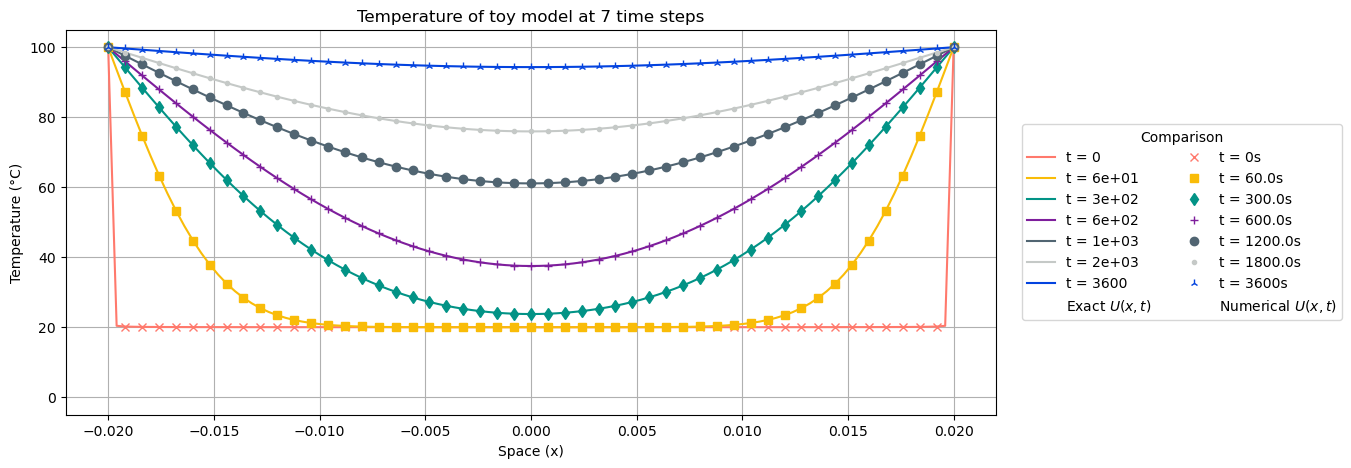

In [73]:
def plot_exact(U,x,t,exact_handle=U_exact_egg,title = "Temperature of toy model at 7 time steps"):
    # Set some markers and colours to make comparison easy
    markers = ['x','s','d','+','o','.','2']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal','xkcd:purple','xkcd:slate','xkcd:silver','xkcd:blue']    
    
    # display times
    disp_times = [0, 60, 300, 600, 1200, 1800, 3600]

    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    # Plot actual curves
    for i, idx_t in enumerate(disp_times):
        label = 't = {0:.0e}'.format(t[idx_t]) if (0 < t[idx_t] < t_max) else 't = {0:.0f}'.format(t[idx_t])
        ax.plot(x, exact_handle(x,t[idx_t]), color = colours[i], label = label)
    ax.scatter([0], [0], color='white', label=r'Exact $U(x,t)$', lw=0)

    for i, idx_t in enumerate(disp_times):
        label = 't = {0}s'.format(t[idx_t]) if (0 < t[idx_t] < t_max) else 't = {0:.0f}s'.format(t[idx_t])
        ax.plot(x[::2], U[idx_t][::2], linestyle = '', marker = markers[i], color = colours[i], label = label )
    ax.scatter([0], [0], color='white', label=r'Numerical $U(x,t)$', lw=0)

    
    ax.legend(ncols = 2, loc = 'center',  bbox_to_anchor=(1.2, 0.5), title ='Comparison')
    #ax.set_xlim(0-1e-2,1.0+1e-2)    # zoom in on area of interest with a bit of leeway each end
    plt.xlabel("Space (x)")
    plt.ylabel("Temperature (°C)")  
    plt.title(title)
    plt.grid(True)
    plt.show()
plot_exact(U_1,x,t)

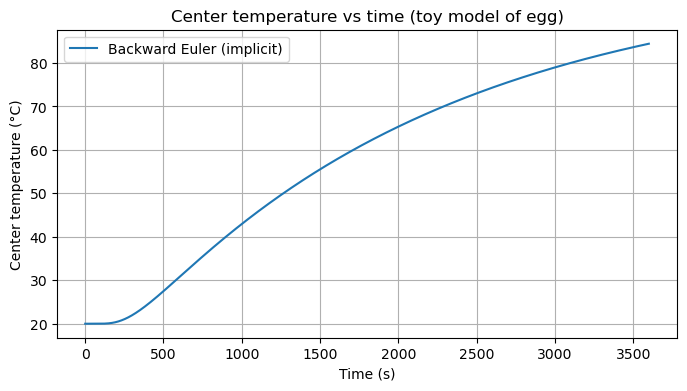

In [65]:
# Center temperature vs time
t_imp_1 = np.linspace(0, t_max, len(center))
plt.figure(figsize=(8,4))
plt.plot(t_imp_1, center, label="Backward Euler (implicit)")
plt.xlabel("Time (s)")
plt.ylabel("Center temperature (°C)")
plt.title("Center temperature vs time (toy model of egg)")
plt.legend()
plt.grid(True)
plt.show()

# Case 2: Heating water from room temp

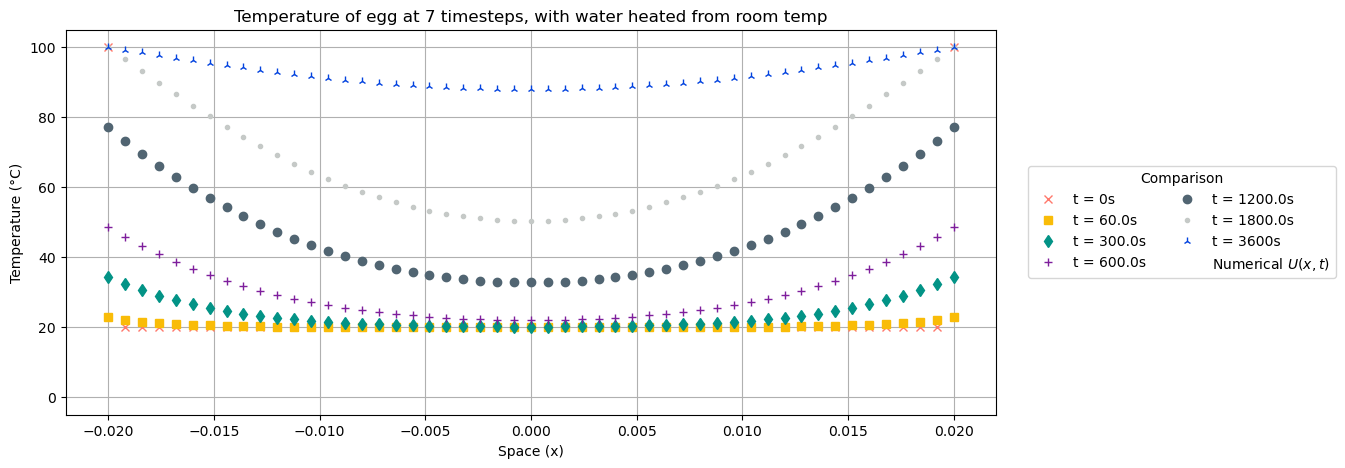

In [75]:
# Initialise U
U_heat = np.zeros((Nt,Nx))
U_heat[0] = I_egg(x)
# Enforce boundary conditions for all space points
U_heat[:,[0,-1]] = T_d

center = []
cent_i = 50
## Iterate
for n in range(0, Nt - 1):
    center.append(U_heat[n,cent_i])
    U_heat[n+1] = spsolve(A, U_heat[n])
    #Same process as before, but replace boundaries with water temp
    U_heat[n+1,[0,-1]] = Water_temp(n,mass=5)

plot_num(U_heat,x,t,title="Temperature of egg at 7 timesteps, with water heated from room temp")

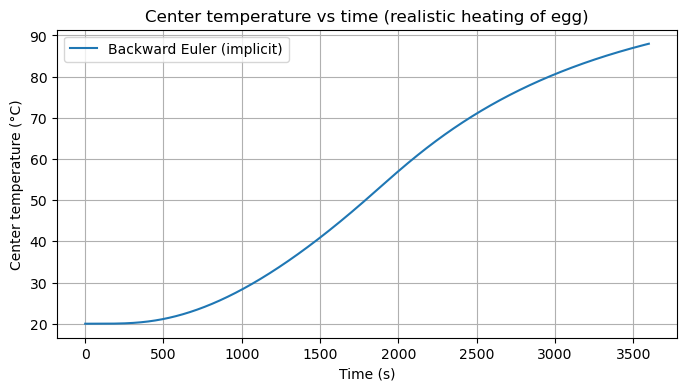

In [67]:
# Center temperature vs time
t_imp_2 = np.linspace(0, t_max, len(center))
plt.figure(figsize=(8,4))
plt.plot(t_imp_2, center, label="Backward Euler (implicit)")
plt.xlabel("Time (s)")
plt.ylabel("Center temperature (°C)")
plt.title("Center temperature vs time (realistic heating of egg)")
plt.legend()
plt.grid(True)
plt.show()

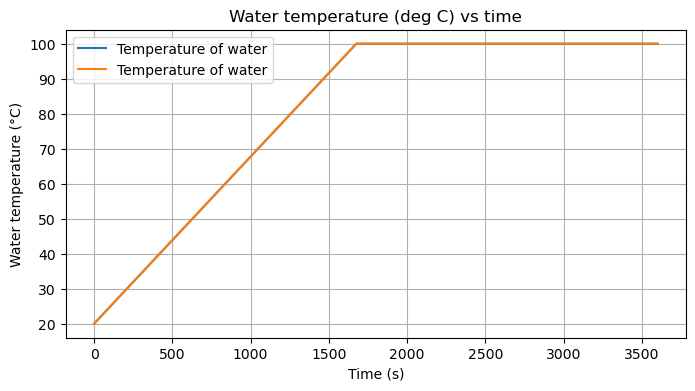

In [68]:
test=[]
for t_1 in t:
    test.append(Water_temp(t_1,mass=5))

plt.figure(figsize=(8,4))
plt.plot(t, test, label="Temperature of water")
plt.xlabel("Time (s)")
plt.ylabel("Water temperature (°C)")
plt.title("Water temperature (deg C) vs time")
plt.legend()
plt.grid(True)
plt.show()

# Case 1 with Variable Diffusivities

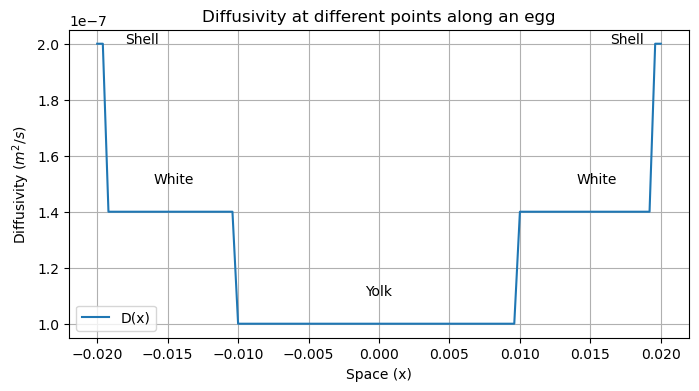

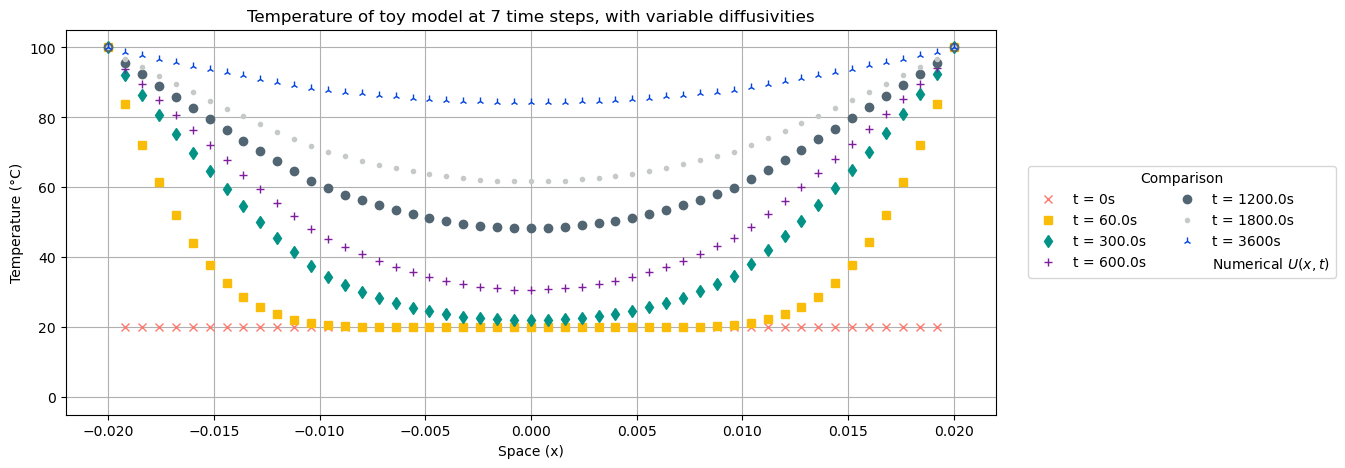

In [76]:
from scipy.sparse import diags as dgs
from scipy.sparse import eye
from scipy.sparse.linalg import spsolve

#Values for diffusivities, Need better vals, just got AI guidance for test purposes
a_shell = 2e-7
a_white = 1.4e-7
a_yolk = 1e-7

#Set up D(x) - Array of diffusivities at each point in space
#Shell is around first 0.5mm, then 95mm of white and 1cm of yolk
D_x = np.ones_like(x)
D_x[0:2] *= a_shell
D_x[-2:] *= a_shell
D_x[25:75]*=a_yolk
D_x[2:25]*=a_white
D_x[75:-2]*=a_white

#Plot D(x) for visual aid
plt.figure(figsize=(8,4))
plt.plot(x, D_x, label="D(x)")
plt.xlabel("Space (x)")
plt.ylabel("Diffusivity $(m^2/s)$")
plt.title("Diffusivity at different points along an egg")

#Label sections
plt.text(x[-10],2e-7,"Shell")
plt.text(0.014,1.5e-7,"White")
plt.text(-0.001,1.1e-7,"Yolk")
plt.text(-0.016,1.5e-7,"White")
plt.text(x[5],2e-7,"Shell")

plt.legend()
plt.grid(True)
plt.show()

# Take del_x of D using gradent function - will be 0 when there is no chand in D, so only takes values at boundaries of material
Del_D=np.gradient(D_x,dx)

#Coefficient for first order centred difference
diff_coeff_first = 1/(2*dx)

# First order centred difference matrix
# Values on the three non-zero diagonals
diags = np.ones((3,Nx))
diags[0]=0          
diags[1] = - diff_coeff_first
diags[2] = diff_coeff_first
diags[1,0] = 0.0
diags[2,-2] = 0.0 
# Create the matrix, taking care of the order in which we defined the diagonals
centred_diff_first = diags_array(diags, offsets = (0,1,-1), shape = (Nx, Nx), format = 'csr')

#Sparse matrix for del_x by D(x)
Diags_Del_D=diags_array(Del_D,format='csr')
#Mutiply Del_x_D by Derivative matrix to get matrix C
Matrix_C = Diag_Del_D@centred_diff_first


#Coefficient for 2nd order centred difference
C = 1/(dx**2)
# Backwards Euler matrix
# Values on the three non-zero diagonals
diags = np.ones((3,Nx))

diags[0,1:-1] = -2 * C             
diags[1:] = C;    
diags[1,0] = 0.0
diags[2,-2] = 0.0 
# Create the matrix, taking care of the order in which we defined the diagonals
A_new = diags_array(diags, offsets = (0,1,-1), shape = (Nx, Nx), format = 'csr')

#Sparse matrix for D(x)
Diag_D = diags_array(D_x,format='csr')
#Multiply D(x) by 2nd order matrix for Matrix D
Matrix_D = Diag_D@A_new

#Add C and D
Final_Matrix = Matrix_D+Matrix_C
sA = sparse.csr_matrix(Final_Matrix)

#Final matrix to solve for u
M =eye(Nx)- sA*dt

# Initialise U
U_3 = np.zeros((Nt,Nx))
U_3[0] = I_egg(x)
# Enforce boundary conditions for all space points
U_3[:,[0,-1]] = T_d


#Plotting
center = []
cent_i = 50
## Iterate
for n in range(0, Nt - 1):
    center.append(U_3[n,cent_i])
    U_3[n+1] = spsolve(matrixypoo, U_3[n])

plot_num(U_3,x,t,title="Temperature of toy model at 7 time steps, with variable diffusivities")


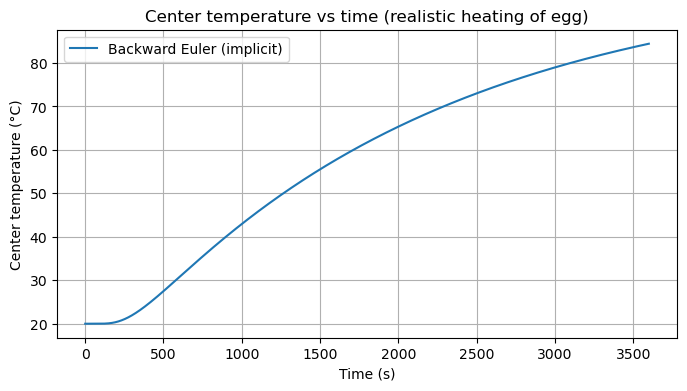

In [71]:
# Center temperature vs time
t_imp_3 = np.linspace(0, t_max, len(center))
plt.figure(figsize=(8,4))
plt.plot(t_imp_3, center, label="Backward Euler (implicit)")
plt.xlabel("Time (s)")
plt.ylabel("Center temperature (°C)")
plt.title("Center temperature vs time (realistic heating of egg)")
plt.legend()
plt.grid(True)
plt.show()

## Ignore: Just plotting two numerical solutions

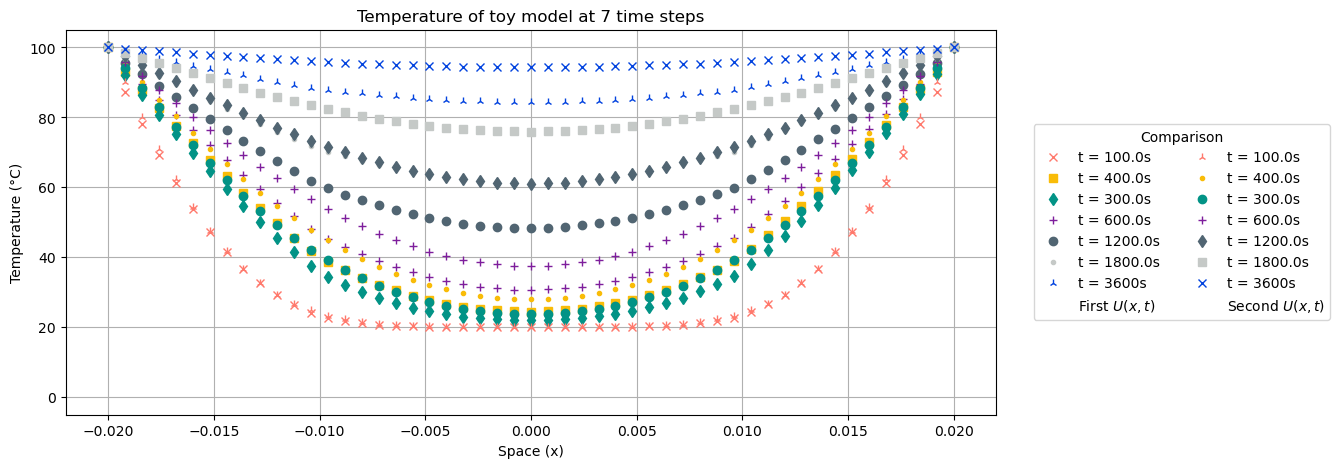

In [77]:
###CODE TO COMPARE TO NUMERICAL SOLTUIONS ROUGHLY

def compar(U,x,t,U_2=U_exact_egg):
    # Set some markers and colours to make comparison easy
    markers = ['x','s','d','+','o','.','2']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal','xkcd:purple','xkcd:slate','xkcd:silver','xkcd:blue']    
    
    # display times
    disp_times = [100, 400, 300, 600, 1200, 1800, 3600]

    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    # Dummy plot for legend titles
    # ax.scatter([0], [0], color='white', label=r'Exact $u(x,t)$', lw=0)

    # Plot actual curves
    for i, idx_t in enumerate(disp_times):
        label = 't = {0}s'.format(t[idx_t]) if (0 < t[idx_t] < t_max) else 't = {0:.0f}s'.format(t[idx_t])
        ax.plot(x[::2], U_2[idx_t][::2], linestyle = '', marker = markers[i], color = colours[i], label = label )

    ax.scatter([0], [0], color='white', label=r'First $U(x,t)$', lw=0)
        
    for i, idx_t in enumerate(disp_times):
        label = 't = {0}s'.format(t[idx_t]) if (0 < t[idx_t] < t_max) else 't = {0:.0f}s'.format(t[idx_t])
        ax.plot(x[::2], U[idx_t][::2], linestyle = '', marker = markers[6-i], color = colours[i], label = label )

    ax.scatter([0], [0], color='white', label=r'Second $U(x,t)$', lw=0)
    
    ax.legend(ncols = 2, loc = 'center',  bbox_to_anchor=(1.2, 0.5), title ='Comparison')
    #ax.set_xlim(0-1e-2,1.0+1e-2)    # zoom in on area of interest with a bit of leeway each end
    plt.xlabel("Space (x)")
    plt.ylabel("Temperature (°C)")  
    plt.title("Temperature of toy model at 7 time steps")
    plt.grid(True)
    plt.show()

compar(U_1,x,t,U_3)